<a href="https://colab.research.google.com/github/anfalsiddiqui45/mental-health-models/blob/main/mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
train_df = pd.read_csv("/content/drive/MyDrive/train.csv")
test_df  = pd.read_csv("/content/drive/MyDrive/test.csv")

X_train = train_df["statement"].tolist()
y_train = train_df["label"].values

X_test = test_df["statement"].tolist()
y_test = test_df["label"].values

In [5]:
!pip install -q sentence-transformers
from sentence_transformers import SentenceTransformer

sbert = SentenceTransformer("all-MiniLM-L6-v2")

X_train_emb = sbert.encode(X_train, batch_size=32, show_progress_bar=True)
X_test_emb  = sbert.encode(X_test, batch_size=32, show_progress_bar=True)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/955 [00:00<?, ?it/s]

Batches:   0%|          | 0/239 [00:00<?, ?it/s]

In [6]:
X_train_t = torch.tensor(X_train_emb, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)

X_test_t = torch.tensor(X_test_emb, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.long)

train_ds = TensorDataset(X_train_t, y_train_t)
test_ds  = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

In [7]:
class_counts = np.bincount(y_train)
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum()

class_weights = torch.tensor(class_weights, dtype=torch.float32)


In [8]:
class MLP(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.net(x)

model = MLP(input_dim=X_train_t.shape[1], num_classes=4)


In [9]:
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [10]:
epochs = 10

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for xb, yb in train_loader:
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss:.4f}")


Epoch 1/10 - Loss: 530.1457
Epoch 2/10 - Loss: 414.7225
Epoch 3/10 - Loss: 382.8628
Epoch 4/10 - Loss: 354.7141
Epoch 5/10 - Loss: 335.4654
Epoch 6/10 - Loss: 314.2647
Epoch 7/10 - Loss: 293.7024
Epoch 8/10 - Loss: 275.8773
Epoch 9/10 - Loss: 260.9713
Epoch 10/10 - Loss: 245.8871


In [11]:
model.eval()
all_preds = []

with torch.no_grad():
    for xb, _ in test_loader:
        logits = model(xb)
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())

print(classification_report(
    y_test,
    all_preds,
    target_names=["Normal", "Depression", "Anxiety", "Stress"]
))


              precision    recall  f1-score   support

      Normal       0.96      0.92      0.94      3269
  Depression       0.95      0.89      0.92      3081
     Anxiety       0.77      0.87      0.82       768
      Stress       0.54      0.79      0.64       517

    accuracy                           0.89      7635
   macro avg       0.80      0.87      0.83      7635
weighted avg       0.91      0.89      0.90      7635



In [12]:
f1 = f1_score(y_test, all_preds, average="macro")
f1


0.8285900589055231

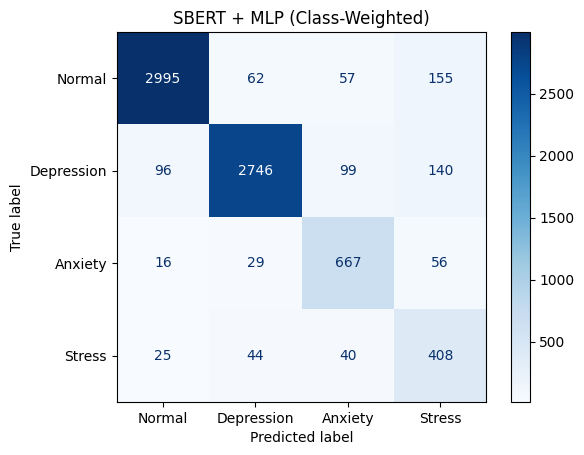

In [13]:
cm = confusion_matrix(y_test, all_preds)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Normal", "Depression", "Anxiety", "Stress"]
)

disp.plot(cmap="Blues")
plt.title("SBERT + MLP (Class-Weighted)")
plt.show()


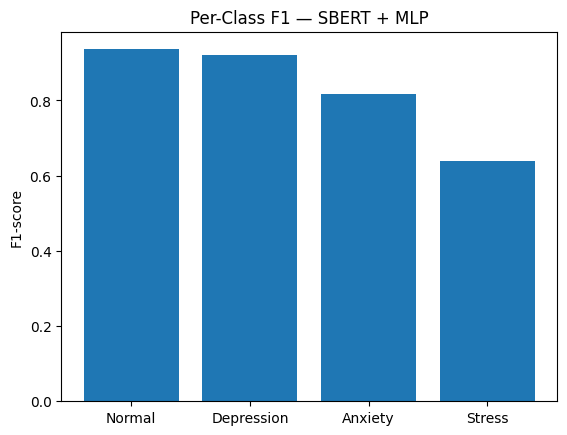

In [14]:
report = classification_report(
    y_test,
    all_preds,
    target_names=["Normal", "Depression", "Anxiety", "Stress"],
    output_dict=True
)

f1_scores = [report[c]["f1-score"] for c in ["Normal", "Depression", "Anxiety", "Stress"]]

plt.bar(["Normal", "Depression", "Anxiety", "Stress"], f1_scores)
plt.ylabel("F1-score")
plt.title("Per-Class F1 — SBERT + MLP")
plt.show()
